# Modelling epidemics evolution SIR model through a factored MDP

brief descrition about this work

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danielbdias/mdp-sir-modelling/blob/master/sir_mdp_example.ipynb)

## Dependencies setup

In [1]:
# Uncomment this line to run this code on Google Colab
#!sh -c "$(curl -fsSL https://raw.githubusercontent.com/danielbdias/mdp-sir-modelling/master/google_colab_setup.sh)"

# enable rich graphs instead of images on notebook
#import mpld3
#mpld3.enable_notebook()

# code dependencies
import time

from sir_modelling.simulation import plot_sir
from sir_modelling.enumerative_model import create_representation
from sir_modelling.enumerative_model_simulation import simulate_policy_with_mdp_model

from mdp.algorithms.value_iteration import enumerative_finite_horizon_value_iteration

## Creating a model

Model parameters

In [2]:
# approximate values by 2 decimal digits
approximation_threshold = 1e-2

# beta (infection rate)
# assumption
# beta < 1.0 - social distancing
# beta >= 1.0 - no social distancing
betas = [0.5, 1.0, 2.5, 4]

# recovery rate (1 person takes 15 days to recover)
gamma = 1.0 / 15.0

horizon = 10 # in weeks
discount_factor = 0.9

steps_per_transition = 7 # each chosen action affects the virus evolution by 7 days (1 week)
initial_state = "s_99_i_01_r_00"

Creating MDP representation

In [3]:
def run_model(approximation_threshold, gamma, betas, steps_per_transition, reward_function, initial_state):
    start_time = time.perf_counter()
    
    # create MDP representation using SIR model
    mdp = create_representation(approximation_threshold, gamma, betas, steps_per_transition, reward_function)
    # run VI on MDP
    policy, value_function, statistics = enumerative_finite_horizon_value_iteration(mdp, discount_factor, horizon)
    # simulate policy
    chosen_betas, S, I, R = simulate_policy_with_mdp_model(policy, initial_state, mdp, horizon, approximation_threshold)

    elapsed_time = time.perf_counter() - start_time
    
    # plot results
    t = list(range(horizon + 1))
    plot_sir(t, S, I, R, time_label="weeks")

    # print chosen betas
    print(chosen_betas)
    
    # print elapsed time
    print(f"Elapsed time: {elapsed_time:0.4f} seconds")

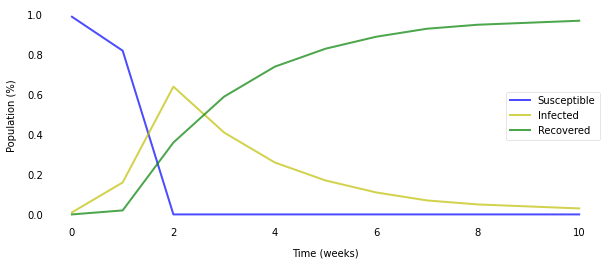

[0.5, 4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Elapsed time: 15.8399 seconds


In [4]:
# weighted reward function (S_weight + R_weight = I_weight)
reward_function = lambda susceptibles, infective, recovered, beta: 10 * susceptibles + 5 * recovered - 15 * infective
run_model(approximation_threshold, gamma, betas, steps_per_transition, reward_function, initial_state)

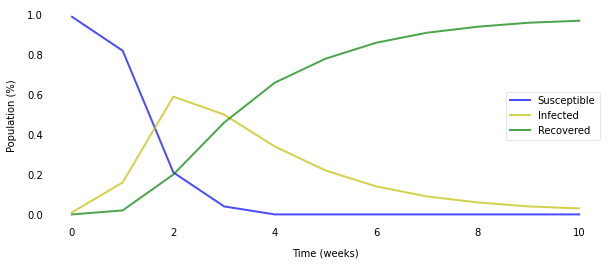

[0.5, 0.5, 0.5, 4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Elapsed time: 15.3637 seconds


In [5]:
# weighted reward function (S_weight + R_weight > I_weight)
reward_function = lambda susceptibles, infective, recovered, beta: 10 * susceptibles + 5 * recovered - 1 * infective
run_model(approximation_threshold, gamma, betas, steps_per_transition, reward_function, initial_state)

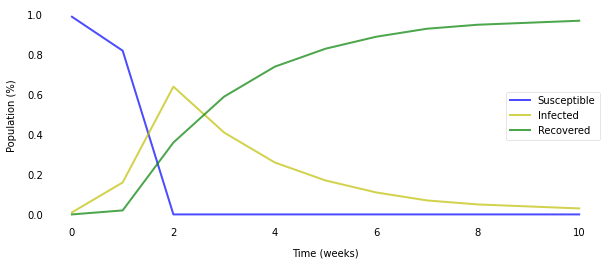

[0.5, 4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Elapsed time: 16.1100 seconds


In [6]:
# weighted reward function (S_weight + R_weight < I_weight)
reward_function = lambda susceptibles, infective, recovered, beta: 10 * susceptibles + 5 * recovered - 30 * infective
run_model(approximation_threshold, gamma, betas, steps_per_transition, reward_function, initial_state)

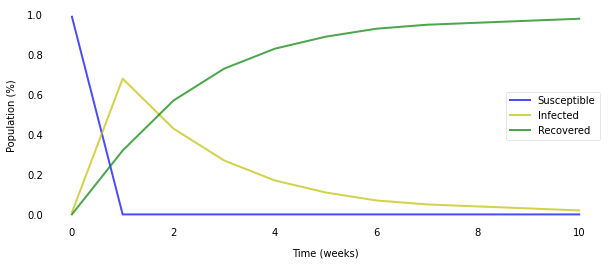

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Elapsed time: 15.5564 seconds


In [7]:
# complex reward function
def reward_function(susceptibles, infective, recovered, beta):
    if infective > 0.75:
        return -10.0

    productivity = beta if beta >= 1.0 else -(susceptibles * beta)
    
    return productivity * (susceptibles + recovered) - 2 * infective

run_model(approximation_threshold, gamma, betas, steps_per_transition, reward_function, initial_state)